# Current progress (6/24/2020)
- I've written a function that will do a "stackplot" of any of the three loan categories' delinquency statuses, based on either percentage of the total number of loans in the deal at that time or in terms of actual numbers of loans
- I can also quickly plot any particular series, although I should probably write a function for that too
- NEXT: ??

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [2]:
# Grab the delinquencies dataset from my Data Repository folder and set up separate dataframes for each loan type (fixed, ARM, and both combined)
# We'll use both the Counts and Balances data
delinq_data = pd.read_pickle('../../data/mbs_data_pickled/delinquency_stats.pkl')
totals = delinq_data[delinq_data.index.get_level_values(1).str.contains('Total')]
fixed = delinq_data[delinq_data.index.get_level_values(1).str.contains('Fixed')]
arm = delinq_data[delinq_data.index.get_level_values(1).str.contains('ARM')]

delinq_data_balances = pd.read_pickle('../../data/mbs_data_pickled/delinquency_stats_balances.pkl')
totals_balances = delinq_data_balances[delinq_data_balances.index.get_level_values(1).str.contains('Total')]
fixed_balances = delinq_data_balances[delinq_data_balances.index.get_level_values(1).str.contains('Fixed')]
arm_balances = delinq_data_balances[delinq_data_balances.index.get_level_values(1).str.contains('ARM')]

# Grab the monthly prepayment amounts dataset
prepayments = pd.read_pickle('../../data/mbs_data_pickled/prepayments.pkl')

In [3]:
# Function that builds a stackplot of any subsection of the delinquency stats data that I want
def plot_delinquencies(data, parameter='counts', legend_loc='lower right',offset=(0.95,0)):
    #Set up the figure and the collection object for the seven time series (each one is a single loan status)
    fig = plt.figure()
    axes = fig.add_axes([0,0,1,1])
    series_for_graph = [0 for x in range(7)]
    months = list(data.index.get_level_values(0).drop_duplicates(keep='first'))
    # Properly assign either loan count or percentage numbers to the collection list
    for i in range(len(data.columns.to_list()[:-1])):
        if parameter == 'counts':
            if 'Number of Loans' in data.columns.to_list():
                series_for_graph[i] = list(data[data.columns.to_list()[i]] * data['Number of Loans'])
            elif 'Total Mortgage Principal Remaining' in data.columns.to_list():
                series_for_graph[i] = list(data[data.columns.to_list()[i]] * data['Total Mortgage Principal Remaining'])
        elif parameter == 'percentages':
            series_for_graph[i] = list(data[data.columns.to_list()[i]])
    # Build the graph and set up the desired formatting
    legend = data.columns.to_list()[:-1]
    output = axes.stackplot(months, series_for_graph, labels=legend)
    axes.legend(reversed(plt.legend().legendHandles), reversed(legend))
    # Choose the title based on the names of the data in the particular dataframe passed in
    title_dict = {'fixed': 'Statuses of Fixed-Rate Mortgages in BSABS 2006-HE10', 'arm': 'Statuses of Adjustable-Rate Mortgages in BSABS ' +               '2006-HE10', 'totals': 'Mortgage Payment Statuses in BSABS 2006-HE10'}
    if data.index.get_level_values(1).str.contains('Total').all():
        title = 'totals'
    elif data.index.get_level_values(1).str.contains('Fixed').all():
        title = 'fixed'
    elif data.index.get_level_values(1).str.contains('ARM').all():
        title = 'arm'
    axes.set_title(title_dict[title])
    # Choose the y-axis label to correctly describe either loan counts or percentages of the overall loan pool
    if 'Number of Loans' in data.columns.to_list():
        ylabel_dict = {'counts': 'Number of Loans', 'percentages': 'Percentage of Monthly Total Loan Count'}
    elif 'Total Mortgage Principal Remaining' in data.columns.to_list():
        ylabel_dict = {'counts': 'Remaining Mortgage Principal (Billions of Dollars)', 'percentages':'Percentage of Remaining Mortgage Principal'}
    axes.set_ylabel(ylabel_dict[parameter])
    # Move the legend to its preferred location based on the parameters entered
    axes.legend(bbox_to_anchor=offset,loc=legend_loc)
    return fig, axes

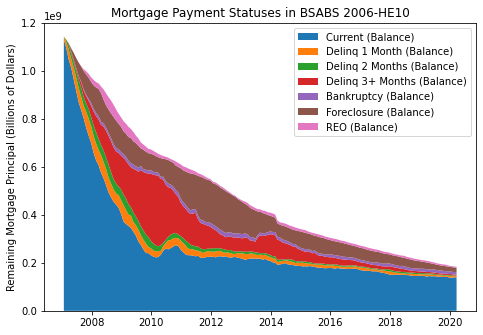

In [4]:
# Here, we show off a graph with the new BALANCES-BASED (as opposed to counts-based) data
fig, ax = plot_delinquencies(totals_balances,parameter='counts',legend_loc = 'upper right', offset=(1,1))
fig.savefig('../../figures/stackplot_delinq_status.png',dpi=200,bbox_inches='tight')

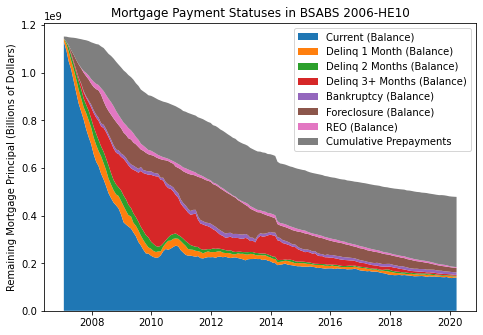

In [5]:
# Now, let's add on prepayments and see what happens
fig3 = plt.figure()
axes3 = fig3.add_axes([0,0,1,1])
series_for_graph3 = [0 for x in range(8)]
months = list(totals_balances.index.get_level_values(0).drop_duplicates(keep='first'))
# Properly assign either loan count or percentage numbers to the collection list
for i in range(len(totals_balances.columns.to_list()[:-1])):
    series_for_graph3[i] = list(totals_balances[totals_balances.columns.to_list()[i]] * totals_balances['Total Mortgage Principal Remaining'])
series_for_graph3[7] = list(prepayments.xs('Total',level=1)['Prepayments'].cumsum())
# Build the graph and set up the desired formatting
legend3 = totals_balances.columns.to_list()[:-1] + ['Cumulative Prepayments']
output3 = axes3.stackplot(months, series_for_graph3, labels=legend3)
axes3.legend(reversed(plt.legend().legendHandles), reversed(legend3))
# Choose the title based on the names of the data in the particular dataframe passed in
title_dict3 = {'fixed': 'Statuses of Fixed-Rate Mortgages in BSABS 2006-HE10', 'arm': 'Statuses of Adjustable-Rate Mortgages in BSABS ' +               '2006-HE10', 'totals': 'Mortgage Payment Statuses in BSABS 2006-HE10'}
if totals_balances.index.get_level_values(1).str.contains('Total').all():
    title = 'totals'
elif totals_balances.index.get_level_values(1).str.contains('Fixed').all():
    title = 'fixed'
elif totals_balances.index.get_level_values(1).str.contains('ARM').all():
    title = 'arm'
axes3.set_title(title_dict3[title])
# Choose the y-axis label to correctly describe either loan counts or percentages of the overall loan pool
ylabel_dict3 = {'counts': 'Remaining Mortgage Principal (Billions of Dollars)', 'percentages':'Percentage of Remaining Mortgage Principal'}
axes3.set_ylabel(ylabel_dict3['counts'])
# Move the legend to its preferred location based on the parameters entered
axes3.legend(bbox_to_anchor=(1,1),loc='upper right')


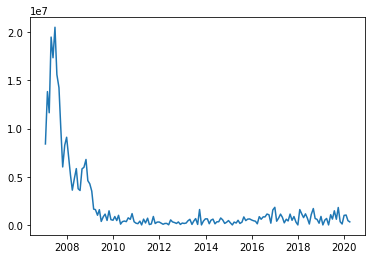

In [6]:
# To get a better understanding of prepayment behavior, I've plotted monthly prepayments here, and cumulative prepayments in the next cell
# As it turns out, the cumulative amount of prepayments in this deal was quite a lot higher than I thought
plt.plot(prepayments.xs('Total',level=1)['Prepayments'])

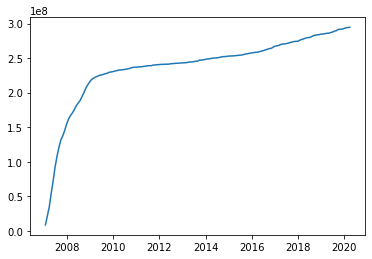

In [7]:
plt.plot(prepayments.xs('Total',level=1)['Prepayments'].cumsum())

<ipython-input-8-3d63c166b755>:41: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig3.show()


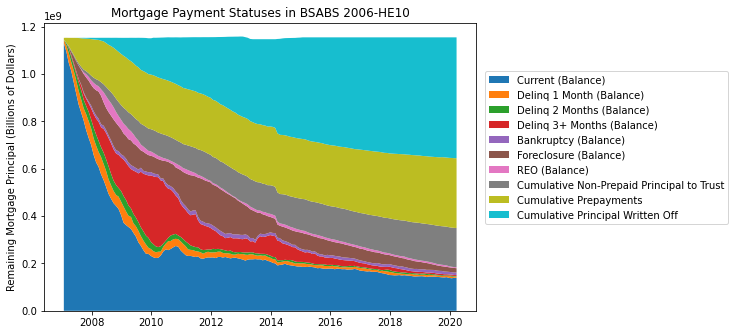

In [8]:
# We could run the same code again, but with remittance principal - prepayments, prepayments, and realized losses as the 'collection' series, to really show how 100% of the original principal balance is accounted for by the various delinquency types, mortgage realized losses, and remittance principal to the trust
# The original version of this graph just used a single "Cumulative Principal Payments to Trust" series instead of total - prepayments and prepayments separately, that graph can be reproduced by altering the code here
remit_trust_with_swap = pd.read_pickle('../../data/mbs_data_pickled/remit_trust_with_swap.pkl')
mortgage_losses = pd.read_pickle('../../data/mbs_data_pickled/realized_losses.pkl')

fig3 = plt.figure()
axes3 = fig3.add_axes([0,0,1,1])
series_for_graph3 = [0 for x in range(10)]
months = list(totals_balances.index.get_level_values(0).drop_duplicates(keep='first'))
# Properly assign either loan count or percentage numbers to the collection list
for i in range(len(totals_balances.columns.to_list()[:-1])):
    series_for_graph3[i] = list(totals_balances[totals_balances.columns.to_list()[i]] * totals_balances['Total Mortgage Principal Remaining'])
series_for_graph3[7] = list(remit_trust_with_swap.xs('Total',level=1)['Remittance Principal'].cumsum() - prepayments.xs('Total',level=1)['Prepayments'].cumsum())
series_for_graph3[8] = list(prepayments.xs('Total',level=1)['Prepayments'].cumsum())
series_for_graph3[9] = list(mortgage_losses.xs('Total',level=1)['Realized Losses'].cumsum())
# Build the graph and set up the desired formatting
legend3 = totals_balances.columns.to_list()[:-1] + ['Cumulative Non-Prepaid Principal to Trust'] +  ['Cumulative Prepayments'] + ['Cumulative Principal Written Off']
output3 = axes3.stackplot(months, series_for_graph3, labels=legend3)
axes3.legend(reversed(plt.legend().legendHandles), reversed(legend3))
# Choose the title based on the names of the data in the particular dataframe passed in
title_dict3 = {'fixed': 'Statuses of Fixed-Rate Mortgages in BSABS 2006-HE10', 'arm': 'Statuses of Adjustable-Rate Mortgages in BSABS ' +               '2006-HE10', 'totals': 'Mortgage Payment Statuses in BSABS 2006-HE10'}
if totals_balances.index.get_level_values(1).str.contains('Total').all():
    title = 'totals'
elif totals_balances.index.get_level_values(1).str.contains('Fixed').all():
    title = 'fixed'
elif totals_balances.index.get_level_values(1).str.contains('ARM').all():
    title = 'arm'
axes3.set_title(title_dict3[title])
# Choose the y-axis label to correctly describe either loan counts or percentages of the overall loan pool
ylabel_dict3 = {'counts': 'Remaining Mortgage Principal (Billions of Dollars)', 'percentages':'Percentage of Remaining Mortgage Principal'}
axes3.set_ylabel(ylabel_dict3['counts'])
# Move the legend to its preferred location based on the parameters entered
axes3.legend(loc=[1.02,.3])
# axes3.text(1.02, 0.1, 'Note: I\'m aware that the sum of\nthese balances isn\'t quite constant over\ntime, but I\'m not yet sure why', transform=axes3.transAxes)
#axes3.text(x=0.5,y=0.5,s='I\'m aware that the sum of these balances isn\'t quite constant over time, but I\'m not yet sure why')
# # Series describing the remaining mortgage principal balance -- confirms that the sum of current + delinq + bankrupt + foreclosure + REO equals the total remaining mortgage pool
# axes3.plot(delinq_data_balances.xs('Total [All Loans]',level=1)['Total Mortgage Principal Remaining'],color='black')
# # Sanity check on the mortgage pool size for the very last month of data that I have, snce I couldn't read the graph closely enough to ensure that the numbers from the above series were matching up with the stackplot
# axes3.axhline(delinq_data_balances.xs('Total [All Loans]',level=1).at['2020-03-25','Total Mortgage Principal Remaining'],color='black')

fig3.show()
fig3.savefig('../../figures/stackplot_delinq_status_with_writeoffs.png',dpi=200,bbox_inches='tight')

In [9]:
prepayments.xs('Total',level=1)['Prepayments'].cumsum().tail(1)

Date
2020-03-25    294660524.57
Name: Prepayments, dtype: object

In [10]:
(remit_trust_with_swap.xs('Total',level=1)['Remittance Principal'].cumsum() - prepayments.xs('Total',level=1)['Prepayments'].cumsum()).tail(1)

Date
2020-03-25    165888197.43
dtype: object

## ANALYSIS
This graph is possibly the single best depiction I have of the mortgage pool's performance over time: we can clearly see how the ratios between various delinquency statuses change as the deal's life goes on, and we also get to see how much of the 'removed' principal was sent to the trust and how much was written off

In [11]:
totals_balances

,,Current (Balance),Delinq 1 Month (Balance),Delinq 2 Months (Balance),Delinq 3+ Months (Balance),Bankruptcy (Balance),Foreclosure (Balance),REO (Balance),Total Mortgage Principal Remaining
Date,,,,,,,,,
2007-01-25,Total [All Loans],0.989,0.011,0.0,0.0,0.0,0.0,0.0,1143360978.59
2007-02-26,Total [All Loans],0.968,0.0242,0.0077,0.0,0.0002,0.0,0.0,1128660759.91
2007-03-26,Total [All Loans],0.9387,0.0373,0.0177,0.0011,0.0004,0.0048,0.0,1114950508.9
2007-04-25,Total [All Loans],0.9266,0.034,0.0199,0.0068,0.0008,0.0119,0.0,1094052498.0
2007-05-25,Total [All Loans],0.8983,0.045,0.0221,0.0068,0.0016,0.0262,0.0,1075799545.74
...,...,...,...,...,...,...,...,...,...
2019-11-25,Total [All Loans],0.742393,0.026302,0.013072,0.025106,0.056535,0.104765,0.031827,191291144.99
2019-12-26,Total [All Loans],0.738048,0.04112,0.015462,0.022192,0.056897,0.10378,0.022502,187979355.07
2020-01-27,Total [All Loans],0.739623,0.034997,0.021735,0.02535,0.055361,0.103295,0.019638,185709299.59


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7fb7773ed520>)

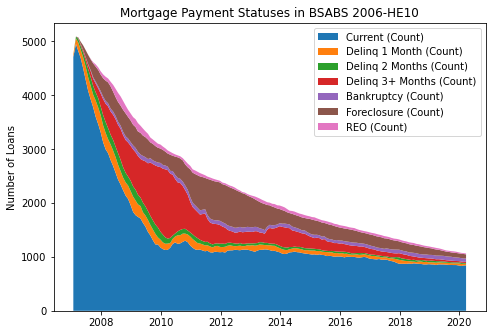

In [12]:
# Recommended legend location: upper right and (1,1) for counts, lower right and (0.95,0) for percentages
plot_to_display = plot_delinquencies(totals,parameter='counts',legend_loc = 'upper right', offset=(1,1))
plot_to_display

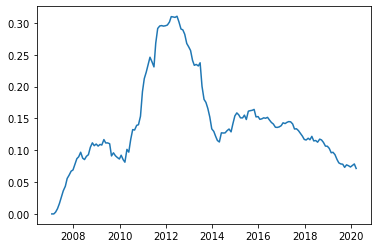

In [13]:
# A simpler plot of any particular series within the delinquency_stats table
plt.plot(totals.index.get_level_values(0),totals['Foreclosure (Count)'].values)

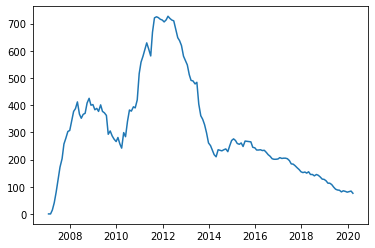

In [14]:
# A second cell for comparing interesting series, since I haven't written a general plotting function yet and I don't know how to output two separate plots from a single cell yet
plt.plot(totals.index.get_level_values(0),(totals['Foreclosure (Count)']*totals['Number of Loans']).values)

<ipython-input-15-76833c214f71>:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  rates_comparison.show()


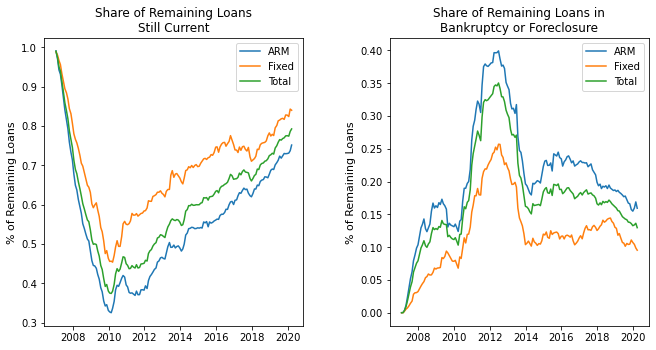

In [15]:
# Let's look at bankruptcy rates for fixed vs. adjustable-rate loans, which is another piece of the puzzle regarding whether ARMs performed worse than fixed-rate loans
rates_comparison = plt.figure()
axes1 = rates_comparison.add_axes([0,0,0.6,1])
axes1.plot(delinq_data.xs('ARM',level=1)['Current (Count)'],label='ARM')
axes1.plot(delinq_data.xs('Fixed',level=1)['Current (Count)'],label='Fixed')
axes1.plot(delinq_data.xs('Total [All Loans]',level=1)['Current (Count)'],label='Total')
axes1.legend()
axes1.set_ylabel('% of Remaining Loans',fontsize=11)
axes1.set_title('Share of Remaining Loans\nStill Current')

axes2 = rates_comparison.add_axes([0.8,0,0.6,1])
axes2.plot(delinq_data.xs('ARM',level=1)['Bankruptcy (Count)']+delinq_data.xs('ARM',level=1)['Foreclosure (Count)'],label='ARM')
axes2.plot(delinq_data.xs('Fixed',level=1)['Bankruptcy (Count)']+delinq_data.xs('Fixed',level=1)['Foreclosure (Count)'],label='Fixed')
axes2.plot(delinq_data.xs('Total [All Loans]',level=1)['Bankruptcy (Count)']+delinq_data.xs('Total [All Loans]',level=1)['Foreclosure (Count)'],label='Total')
axes2.legend()
axes2.set_ylabel('% of Remaining Loans',fontsize=11)
axes2.set_title('Share of Remaining Loans in\nBankruptcy or Foreclosure')
rates_comparison.show()

rates_comparison.savefig('../../figures/timeseries_delinq_status_fixed_vs_arm.png',dpi=200,bbox_inches='tight')

How do we reconcile the huge difference in volumes of loans in bankruptcy/foreclosure and the minimal difference in loan balance loss rates? Some of it might be due to the counts vs. dollar values difference, but my best guess is just that since the realized losses data ends in May 2013, we can see that that's roughly where the bankruptcy/foreclosure numbers start to collapse, so right after that point is probably where the disproportionately realized losses for the ARMs start getting booked in the remittance reports.

Recall that the reason we can't do realized losses data broken out by Fixed vs ARM after May 2013 is that the new-format investor reports only do Group I vs. Group II, not Fixed vs. ARM or by more specific loan type